<a href="https://colab.research.google.com/github/AmoghTantradi/CS182-final-project/blob/main/Composite_Image_for_Multisubject_Dreambooth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Composite Images for Dreambooth Multiobject

In [ ]:
import cv2
import numpy as np
from skimage import segmentation
from google.colab.patches import cv2_imshow

def isolate_subject(image_path):
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = np.zeros(image.shape[:2], np.uint8)

    #background and foreground models for grabCut
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)


    rect = (10, 10, image.shape[1]-10, image.shape[0]-10)
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    # Create a mask with foreground and probable foreground pixels
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')

    # Apply mask to image
    subject = image * mask2[:,:,np.newaxis]

    return subject, mask2

def average_background_color(image, mask):
    background_mask = cv2.bitwise_not(mask)
    background = cv2.bitwise_and(image, image, mask=background_mask)
    avg_color_per_row = np.average(background, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)

    return avg_color

def create_composite_image(image1_path, image2_path):
    subject1, mask1 = isolate_subject(image1_path)
    subject2, mask2 = isolate_subject(image2_path)

    avg_color1 = average_background_color(subject1, mask1)
    avg_color2 = average_background_color(subject2, mask2)

    # Average the background colors
    final_bg_color = np.mean([avg_color1, avg_color2], axis=0)

    # Resize subjects for uniformity (if needed)
    ratio1 = subject1.shape[0]/subject1.shape[1]
    ratio2 = subject2.shape[0]/subject2.shape[1]
    subject1 = cv2.resize(subject1, (300, int(ratio1*300)))
    subject2 = cv2.resize(subject2, (300, int(ratio2*300)))

    # Create final image
    final_image_height = max(subject1.shape[0], subject2.shape[0])
    final_image_width = subject1.shape[1] + subject2.shape[1]
    final_image = np.full((final_image_height, final_image_width, 3), final_bg_color, dtype=np.uint8)

    # Place subjects on the final image
    final_image[:subject1.shape[0], :subject1.shape[1]] = subject1
    final_image[:subject2.shape[0], subject1.shape[1]:subject1.shape[1]+subject2.shape[1]] = subject2

    black_pixels_mask = np.all(final_image == [0, 0, 0], axis=-1)
    final_image[black_pixels_mask] = final_bg_color


    return final_image


"# Example usage\ncomposite_image = create_composite_image('1.jpg', '0.jpeg')\ncv2_imshow(cv2.cvtColor(composite_image, cv2.COLOR_BGR2RGB))\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n"

In [ ]:
oski_urls = [
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/oski-1.jpeg",
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/oski-2.jpeg",
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/oski-3.jpeg",
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/oski-4.jpeg",
      ]
teddy_urls = [
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/teddy-1.png",
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/teddy-2.png",
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/teddy-3.png",
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/teddy-4.png",
      ]

In [ ]:
import requests
import glob
import PIL
from PIL import Image
from io import BytesIO
import os

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

oski_images = list(filter(None,[download_image(url) for url in oski_urls]))
teddy_images = list(filter(None,[download_image(url) for url in teddy_urls]))
save_path = "./my_concept"
save_path2 = "./my_concept2"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(oski_images)]
if not os.path.exists(save_path2):
  os.mkdir(save_path2)
_ =[image.save(f"{save_path2}/{i}.jpeg") for i, image in enumerate(teddy_images)]


Replace images1 and images2

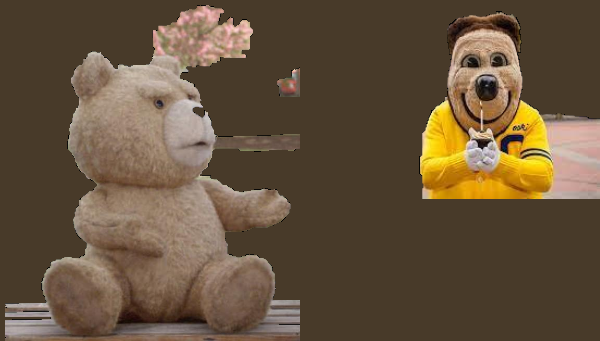

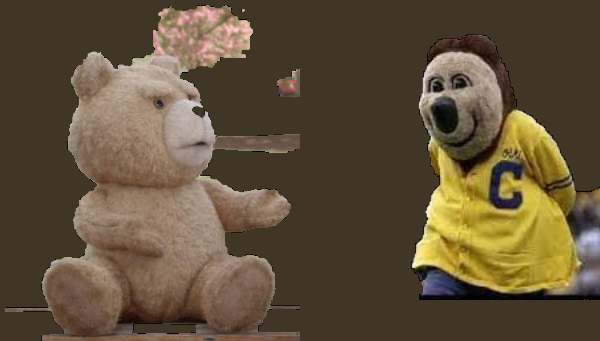

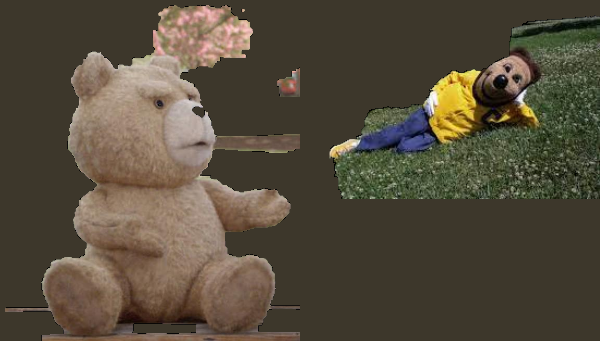

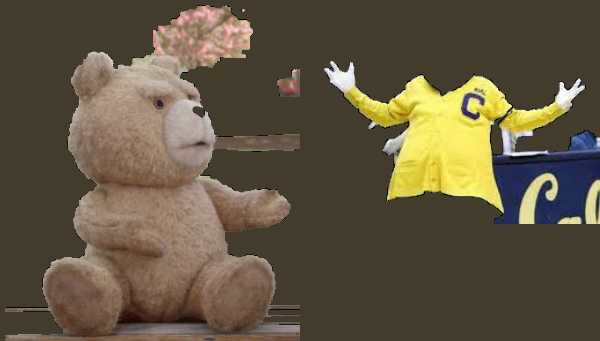

KeyboardInterrupt: ignored

In [ ]:
images1 = [f"./my_concept/{i}.jpeg" for i in range(4)]
images2= [f"./my_concept2/{i}.jpeg" for i in range(4)]

for im1 in images2:
  for im2 in images1:
    composite_image = create_composite_image(im1, im2)
    cv2_imshow(cv2.cvtColor(composite_image, cv2.COLOR_BGR2RGB))
    cv2.waitKey(0)
    cv2.destroyAllWindows()